In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.lines import Line2D
import numpy as np
from carps.analysis.utils import savefig

sns.set_theme(font_scale=2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

path = Path("BB_1/default")
scenario = "blackbox"
path = Path("MF_0/default")
scenario = "multi-fidelity"
# path = Path("MO_0")
# scenario = "multi-objective"
# path = Path("BB_1/lognorm")
# scenario = "blackbox"
selected_subset_size = 30

figsize = (5,2)

In [34]:
# INSPECT SOURCE SET
# Plot df_crit
# Source
# filename = "../MF_df_crit.parquet"
# full_set = pd.read_parquet(filename)

sns.set_theme(font_scale=1)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

full_set = pd.read_csv(path / "df_crit.csv")
full_set["problem_id"] = full_set["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
full_set = full_set.set_index("problem_id", drop=True)
axes_labels = list(full_set.columns)

full_set = full_set.map(lambda x: np.log10(x+1e-10))  # avoid inf
def norm(x: pd.Series) -> pd.Series:
    return (x - x.min()) / (x.max() - x.min())
full_set = full_set.transform(norm)
full_set.to_csv(path / "df_crit_log_norm.csv")

def add_benchmark_id(x: pd.Series) -> pd.Series:
    problem_ids = x.to_numpy()
    def which_benchmark(problem_id: str):
        if problem_id.startswith("bbob"):
            return "BBOB"
        elif problem_id.startswith("hpobench"):
            return "HPOBench"
        elif problem_id.startswith("hpob"):
            return "HPOB"
        elif problem_id.startswith("yahpo"):
                return "YAHPO"
        elif problem_id.startswith("mfpbench"):
                return "MFPBench"
        elif problem_id.startswith("Pymoo"):
                return "Pymoo"
        else:
             raise ValueError(f"Unknown problem_id {problem_id}")
    benchmark_ids = [which_benchmark(p) for p in problem_ids]
    return benchmark_ids

full_set["benchmark_id"] = add_benchmark_id(full_set.index)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
points = full_set.to_numpy()
ax.scatter(points[:,0], points[:,1], points[:,2], label="full", alpha=1)
ax.set_xlabel(axes_labels[0])
ax.set_ylabel(axes_labels[1])
ax.set_zlabel(axes_labels[2])
ax.legend()
fig.set_tight_layout(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (gid, gdf) in enumerate(full_set.groupby("benchmark_id")):
    points = gdf.to_numpy()
    ax.scatter(points[:,0], points[:,1], points[:,2], label=str(gid), alpha=1, marker=markers[i+1])
ax.set_xlabel(axes_labels[0])
ax.set_ylabel(axes_labels[1])
ax.set_zlabel(axes_labels[2])
ax.legend()
fig.set_tight_layout(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'MF_0/default/df_crit.csv'

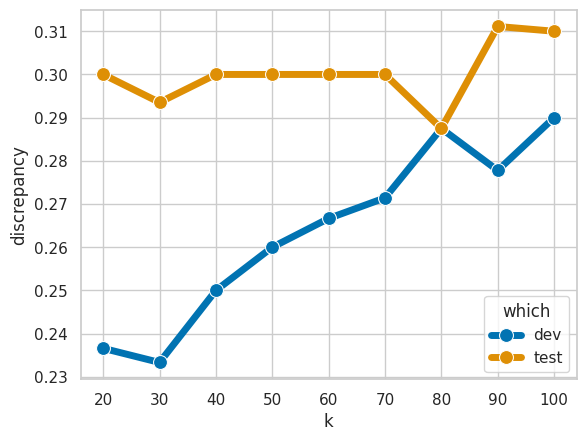

In [ ]:
df = pd.read_csv(path / "info.csv")
df["which"] = df["which"].apply(lambda x: "dev" if x == "s1" else "test")

fig, ax = plt.subplots()
ax = sns.lineplot(data=df, x="k", y="discrepancy", hue="which", marker="o", ax=ax, linewidth=5, markersize=10)
savefig(fig=fig, filename=f"{scenario}_different_k")

full set size 2283


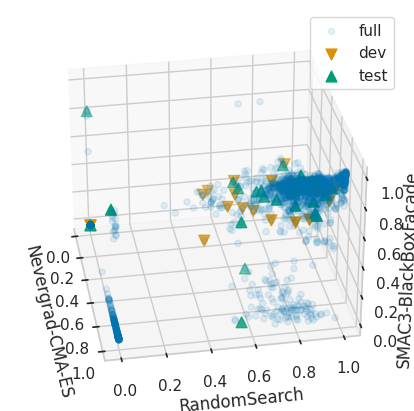

[10.  4.]


In [ ]:
full_set = pd.read_csv(path / "df_crit.csv", index_col="problem_id")
print("full set size", len(full_set))
axes_labels = list(full_set.columns)
subset_paths = list(path.glob("subset*"))
subset_paths.sort()
ks = np.array([int(p.name.split(".")[0].split("_")[-1]) for p in subset_paths])
ids = np.argsort(ks)
subset_paths = np.array(subset_paths)[ids]
ks = ks[ids]
subsets = [pd.read_csv(p, index_col="problem_id") for p in subset_paths]

markers = list(Line2D.markers.keys())

factor = 2
fig = plt.figure(figsize=(figsize[0]*factor, figsize[1]*factor), layout="constrained")
ax = fig.add_subplot(111, projection='3d')

points = full_set.to_numpy()
ax.scatter(points[:,0], points[:,1], points[:,2], label="full", alpha=0.1)

for i, subset in enumerate(subsets):
    points = subset.to_numpy()
    if ks[i] == selected_subset_size:
        label = ks[i]
        if "complement" in str(subset_paths[i]):
            label = "test"
        else:
            label = "dev"
        ax.scatter(points[:,0], points[:,1], points[:,2], label=label, marker=markers[i+1], s=60)

ax.set_xlabel(axes_labels[0])
ax.set_ylabel(axes_labels[1])
ax.set_zlabel(axes_labels[2])
ax.zaxis.labelpad=-0.7

ax.legend()

ax.view_init(30,-10)
# fig.set_tight_layout({"pad": 0.5}) 

savefig(fig, f"{scenario}_selected_set")
plt.show()

figsize = fig.get_size_inches()# *fig.dpi
print(figsize)

In [ ]:
figsizes

array([10.,  4.])

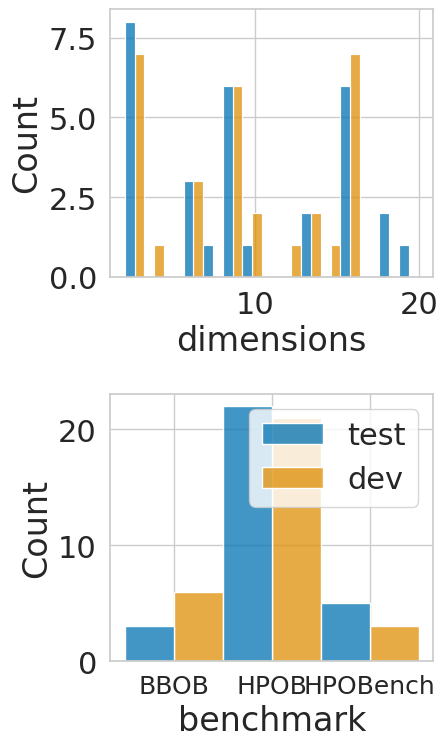

In [ ]:
from carps.analysis.gather_data import maybe_postadd_task


selected_problems = pd.concat([pd.DataFrame({
    "problem_id": list(subsets[i].index),
    "k": [ks[i]] * len(list(subsets[i].index)),
    "set": "test" if "complement" in str(subset_paths[i]) else "dev"
}) for i in range(len(subsets))])
selected_problems = selected_problems.sort_values(by="problem_id")
selected_problems["problem_id"] = selected_problems["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
selected_problems = maybe_postadd_task(selected_problems, overwrite=True)
selected_problems["benchmark"] = add_benchmark_id(selected_problems["problem_id"])

sns.set_theme(font_scale=1)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# fig, ax = plt.subplots(figsize=(20,4))
# ax = sns.histplot(data=selected_problems, x="problem_id", y="k", ax=ax)
# ax.tick_params(axis="x", rotation=90, labelsize=6)
# plt.show()

sns.set_theme(font_scale=2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(figsize[0]*0.5, figsize[1]*2))
axes = fig.subplots(nrows=2)

ax = axes[0]
ax = sns.histplot(data=selected_problems[selected_problems["k"]==selected_subset_size], x="task.dimensions", bins=selected_subset_size//2, hue="set", multiple="dodge", ax=ax)
ax.set_xlabel("dimensions")
ax.legend_.set_title(None)
ax.get_legend().remove()

ax = axes[1]
ax = sns.histplot(data=selected_problems[selected_problems["k"]==selected_subset_size], x="benchmark", hue="set", multiple="dodge", ax=ax)
ax.legend_.set_title(None)
ax.tick_params(axis="x", rotation=0, labelsize=18)

fig.set_tight_layout(True)
savefig(fig, f"{scenario}_selected_stats")
plt.show()

